<a href="https://colab.research.google.com/github/beyzaturku/image_processing_in_autonomous_vehicles/blob/main/car_detect_and_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install ultralytics
!pip install deep-sort-realtime
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
!pip install deep-sort-realtime

In [ ]:
import os
import cv2
import numpy as np
import torch
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from google.colab import files
from IPython.display import display, HTML
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
print("Lütfen bir test videosu yükleyin:")
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

Lütfen bir test videosu yükleyin:


Saving 4608285-uhd_3840_2160_24fps.mp4 to 4608285-uhd_3840_2160_24fps.mp4


In [ ]:
print("YOLOv8 modeli yükleniyor...")
model = YOLO("yolov8m.pt")

YOLOv8 modeli yükleniyor...


In [ ]:
# Araç sınıfları
arac_siniflari = [2, 3, 5, 7]  # 2:araba, 3:motosiklet, 5:otobüs, 7:kamyon
sinif_isimleri = {2: "Araba", 3: "Motosiklet", 5: "Otobüs", 7: "Kamyon"}

In [ ]:
# DeepSORT Takipçisini Başlatma
tracker = DeepSort(max_age=30)

In [ ]:
# Takip edilen araçlar için renk listesi
np.random.seed(42)  # Tutarlı renkler için
COLORS = np.random.randint(0, 255, size=(100, 3), dtype="uint8")

In [ ]:
def process_video(input_path, output_path, box_scale=0.8):
    """
    Video işleme fonksiyonu - geliştirilmiş versiyonu

    Parametreler:
    - input_path: Giriş video dosyasının yolu
    - output_path: Çıkış video dosyasının yolu
    - box_scale: Kutu boyutunu küçültme faktörü (0-1 arasında)
    """
    # Video akışını başlat
    cap = cv2.VideoCapture(input_path)

    # Video özellikleri
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Video yazıcıyı ayarla
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # İstatistikler için değişkenler
    frame_count = 0
    arac_sayilari = {2: 0, 3: 0, 5: 0, 7: 0}  # Sınıf başına araç sayısı
    aktif_araclar = {2: 0, 3: 0, 5: 0, 7: 0}  # Anlık aktif araç sayısı

    # Takip geçmişi için sözlük
    track_history = {}  # Her ID için konum geçmişi
    track_speed = {}    # Her ID için hız tahmini

    # FPS hesaplama için zaman
    prev_time = cv2.getTickCount()

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        # Her kareyi işleme (performans için 2 karede bir)
        if frame_count % 2 != 0:
            out.write(frame)
            continue

        # FPS hesapla
        curr_time = cv2.getTickCount()
        time_diff = (curr_time - prev_time) / cv2.getTickFrequency()
        fps_calc = 1.0 / time_diff
        prev_time = curr_time

        # YOLOv8 ile araç tespiti yap
        results = model(frame)

        # Tespit edilen nesneleri işle
        detections = []

        for result in results:
            boxes = result.boxes.cpu().numpy()

            for box in boxes:
                # Tespit edilen nesnenin sınıfını kontrol et
                class_id = int(box.cls[0])

                # Eğer tespit edilen nesne bir araç ise
                if class_id in arac_siniflari:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    confidence = float(box.conf[0])

                    # Güven skoru %50'den fazla ise
                    if confidence > 0.5:
                        # Kutuları küçültme (box_scale parametresi ile)
                        center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
                        box_width = int((x2 - x1) * box_scale)
                        box_height = int((y2 - y1) * box_scale)

                        # Yeni kutu koordinatları
                        x1_new = max(0, center_x - box_width // 2)
                        y1_new = max(0, center_y - box_height // 2)
                        x2_new = min(width, center_x + box_width // 2)
                        y2_new = min(height, center_y + box_height // 2)

                        # DeepSORT için tespit bilgilerini hazırla
                        detection = [[x1_new, y1_new, x2_new - x1_new, y2_new - y1_new], confidence, class_id]  # Change here
                        detections.append(detection)

        # DeepSORT ile araçları takip et
        if detections:
            tracks = tracker.update_tracks(detections, frame=frame)

            # Sınıf başına aktif araç sayısını sıfırla
            for cls_id in aktif_araclar:
                aktif_araclar[cls_id] = 0

            # Takip edilen araçları çiz
            for track in tracks:
                if not track.is_confirmed():
                    continue

                # Takip edilen aracın sınırlayıcı kutusu
                ltrb = track.to_ltrb()
                x1, y1, x2, y2 = map(int, ltrb)

                # Takip ID'si
                track_id = track.track_id

                if isinstance(track_id, str):
                    track_id = int(track_id)

                # Sınıf bilgisini al
                class_id = None
                if hasattr(track, 'det_class'):
                    class_id = track.det_class
                elif hasattr(track, 'class_id'):
                    class_id = track.class_id

                # ID'ye göre renk seç
                color = [int(c) for c in COLORS[track_id % len(COLORS)]]

                # Sınırlayıcı kutuyu çiz
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

                # Araç merkezi
                center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
                center_point = (center_x, center_y)

                # Hareket yönü için konum geçmişini güncelle
                if track_id not in track_history:
                    track_history[track_id] = []

                # Son 20 konumu sakla
                track_history[track_id].append(center_point)
                if len(track_history[track_id]) > 20:
                    track_history[track_id].pop(0)

                # Hareket izini çiz
                if len(track_history[track_id]) > 1:
                    for i in range(1, len(track_history[track_id])):
                        # Nesnenin geçmiş konumlarını çiz
                        pt1 = track_history[track_id][i-1]
                        pt2 = track_history[track_id][i]
                        cv2.line(frame, pt1, pt2, color, 2)

                # Hız tahmini
                if track_id in track_speed:
                    last_pos, last_time = track_speed[track_id]

                    # Önceki ve şimdiki konum arasındaki mesafe
                    dist = np.sqrt((center_x - last_pos[0])**2 + (center_y - last_pos[1])**2)
                    time_elapsed = frame_count - last_time

                    # Gerçek hıza dönüştürme (örnek bir hesaplama)
                    # Not: Bu hesaplamanın doğruluğu için kalibre edilmesi gerekir
                    speed = dist / time_elapsed * fps * 0.1  # Örnek bir ölçeklendirme faktörü

                    # Hızı ekrana yazdır
                    cv2.putText(frame, f"{speed:.1f} km/s", (x1, y1 - 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                # Hız tahmini için şimdiki pozisyonu kaydet
                track_speed[track_id] = (center_point, frame_count)

                # Eğer nesne ilk kez takip ediliyorsa sayacı artır
                if track.is_confirmed() and track.time_since_update == 0:
                    # Araç türünü belirle
                    if class_id in arac_siniflari:
                        # Toplam sayım
                        arac_sayilari[class_id] += 1
                        # Aktif araç sayısı
                        aktif_araclar[class_id] += 1

                # Takip ID'sini ve sınıf bilgisini göster
                if class_id is not None and class_id in arac_siniflari:
                    text = f"ID: {track_id} - {sinif_isimleri[class_id]}"
                else:
                    text = f"ID: {track_id}"

                cv2.putText(frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # İstatistik bilgilerini ekrana yazdır
        # Sol üst köşeye genel bilgiler
        cv2.putText(frame, f"FPS: {fps_calc:.1f}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        cv2.putText(frame, f"Kare: {frame_count}", (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Sağ üst köşeye araç sayıları
        y_pos = 30
        cv2.putText(frame, "Anlik Araclar:", (width - 200, y_pos),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        y_pos += 30

        for class_id in arac_siniflari:
            sinif_text = f"{sinif_isimleri[class_id]}: {aktif_araclar[class_id]}"
            cv2.putText(frame, sinif_text, (width - 200, y_pos),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            y_pos += 30

        # Sağ alt köşeye toplam araç sayıları
        y_pos = height - 150
        cv2.putText(frame, "Toplam Araclar:", (width - 200, y_pos),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        y_pos += 30

        for class_id in arac_siniflari:
            sinif_text = f"{sinif_isimleri[class_id]}: {arac_sayilari[class_id]}"
            cv2.putText(frame, sinif_text, (width - 200, y_pos),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            y_pos += 30

        # Sonucu kaydet
        out.write(frame)

    # İstatistikleri hesapla ve yazdır
    print(f"Toplam islenen kare sayisi: {frame_count}")
    print(f"Tespit edilen arac sayilari:")
    for class_id, count in arac_sayilari.items():
        print(f"  {sinif_isimleri[class_id]}: {count}")

    # Temizleme
    cap.release()
    out.release()
    return arac_sayilari

Video işleniyor...

0: 384x640 4 cars, 1012.8ms
Speed: 5.4ms preprocess, 1012.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 1 skis, 932.9ms
Speed: 6.3ms preprocess, 932.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 938.6ms
Speed: 4.5ms preprocess, 938.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 1454.4ms
Speed: 4.3ms preprocess, 1454.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 1457.0ms
Speed: 12.8ms preprocess, 1457.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 1090.4ms
Speed: 11.5ms preprocess, 1090.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 929.0ms
Speed: 6.1ms preprocess, 929.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck

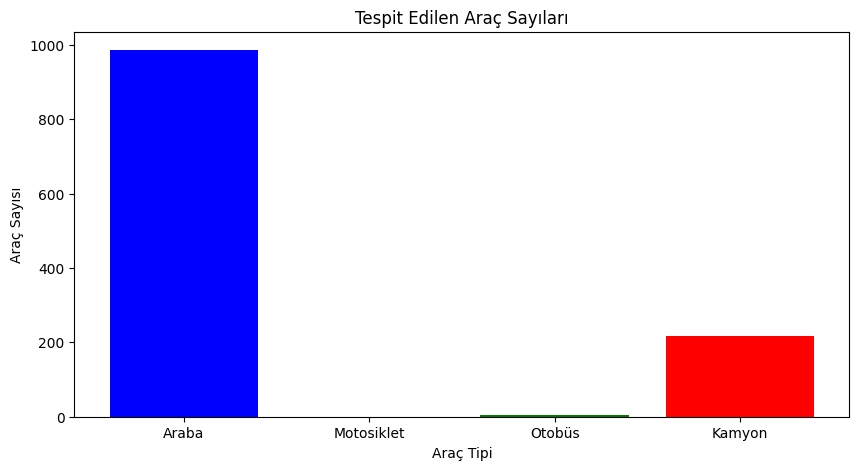

İşlenmiş video indiriliyor...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

İşlem tamamlandı!


In [ ]:
# Video İşleme ve Sonucu İndirme
output_path = "sonuc_video.mp4"
print("Video işleniyor...")

# Kutu ölçeği parametresi eklenmiştir (0.8 = orijinal kutunun %80'i)
arac_sayilari = process_video(video_path, output_path, box_scale=0.8)

# Grafiği oluştur
plt.figure(figsize=(10, 5))
siniflar = [sinif_isimleri[id] for id in arac_siniflari]
sayilar = [arac_sayilari[id] for id in arac_siniflari]
plt.bar(siniflar, sayilar, color=['blue', 'orange', 'green', 'red'])
plt.title('Tespit Edilen Araç Sayıları')
plt.xlabel('Araç Tipi')
plt.ylabel('Araç Sayısı')
plt.savefig('arac_istatistik.png')
plt.show()

# İşlenmiş videoyu indirme
print("İşlenmiş video indiriliyor...")
files.download(output_path)
files.download('arac_istatistik.png')

print("İşlem tamamlandı!")